In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10

from scipy.ndimage.interpolation import zoom
import VGG
import numpy as np
import os
import gradcamutils
from PIL import Image

Using TensorFlow backend.
/home/reza/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/reza/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/reza/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/reza/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
vggModel = VGG.VGG19((352,320,1),4, False) #set up model architecture

vggModel.summary()
vggModel.load_weights("/home/reza/DeepKneeExplainer/resources/old_models/balanced JSN/VGG19-JSNnewbalance-front-0.8896.h5") #load weights


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 352, 320, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 352, 320, 2)       20        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 352, 320, 2)       38        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 176, 160, 2)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 176, 160, 4)       76        
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 176, 160, 4)       148       
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 88, 80, 4)         0    

In [3]:
imgXray = Image.open("1238_R.png") #open image you want to visualize
#imgMRI = Image.open("/home/reza/DeepKneeExplainer/resources/Data/MRI/balancedMRI/up/training/2722_RRRRRRRR.png") #open image you want to visualize

imgXray = np.array(imgXray.resize((320,352), Image.ANTIALIAS))
imXray = imgXray.reshape(1,352,320,1)#open image you want to visualize

In [4]:
import innvestigate

'''
All possible names are: ['input', 'random', 'gradient', 'gradient.baseline', 'input_t_gradient', 
'deconvnet', 'guided_backprop', 'integrated_gradients', 'smoothgrad', 'lrp', 'lrp.z', 'lrp.z_IB', 
'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 
'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 
'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 
'lrp.sequential_preset_b_flat', 'deep_taylor', 'deep_taylor.bounded', 'deep_lift.wrapper', 
'pattern.net', 'pattern.attribution']"
'''

model = vggModel
#analyzer = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model)
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a_flat", model)

In [5]:
# Add batch axis and preprocess
x = imXray / 255.
analysis = analyzer.analyze(x)

In [6]:
a = analysis
a /= np.max(np.abs(a))

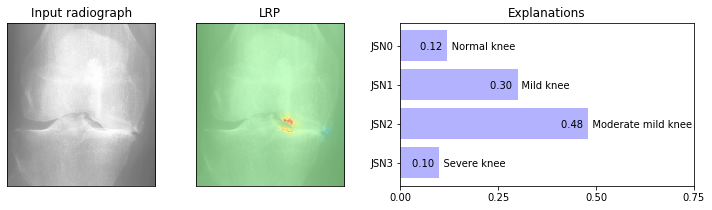

In [7]:
def remove_ticks_and_labels(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

fig = plt.figure(constrained_layout=False,figsize=[6,3])
gs1 = fig.add_gridspec(nrows=1, ncols=2, left=1, right=1.8)

fig_ax1 = fig.add_subplot(gs1[0, 0])
fig_ax2 = fig.add_subplot(gs1[0, 1])

gs2 = fig.add_gridspec(nrows=1, ncols=1, left=1.92, right=2.6)

fig_ax3 = fig.add_subplot(gs2[0, 0])

fig_ax1.imshow(imgXray, cmap ='gray')
fig_ax1.set_title("Input radiograph")
remove_ticks_and_labels(fig_ax1)

fig_ax2.imshow(imgXray, cmap ='gray')
fig_ax2.imshow(a[0,:,:,0], vmax = 1, vmin = -1,alpha=0.45, cmap="jet")
fig_ax2.set_title("LRP")
remove_ticks_and_labels(fig_ax2)

x_probs = [0.12, 0.30, 0.48, 0.10]
x_probs = np.asarray(x_probs, dtype=np.float32)
y_pos = np.array([0, 1, 2, 3])
y_objects = ('JSN0','JSN1','JSN2','JSN3')
y_labels = ['Normal knee', 'Mild knee', 'Moderate mild knee', 'Severe knee']

fig_ax3.barh(y_pos, x_probs, color='blue', align='center', alpha=0.3)
fig_ax3.set_title("Explanations")
for i, v in enumerate(x_probs):
    fig_ax3.text(v - 0.07, i + 0.1 , '{0:.2f}   {1}'.format(v,y_labels[i]))
fig_ax3.set_yticks(y_pos)
fig_ax3.set_yticklabels(y_objects)
fig_ax3.invert_yaxis()  
fig_ax3.set_xticks([0, 0.25, 0.5, 0.75])

fig.savefig('VGGPlotsNetprob.png')